# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 11 — The Kalman filter


---
Submission by: Batuhan, Oezcoemlekci(Matrikelnummer: 6300476) and Aakarsh, Nair( Matrikelnummer: 6546577)

In [44]:
import numpy as np

from matplotlib import pyplot as plt
from numpy.typing import ArrayLike

import scipy.io as sio
import scipy.linalg as sla
import scipy.special as ssp

from tueplots import bundles
from tueplots.constants.color import rgb

# plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

# Exercise 12 (Coding Exercise)

In this exercise, you will implement a Rauch-Tung-Striebel (RTS) smoother.
We will work on the same data as before so you will recognize parts of the notebook from the previous exercise.


**As before, only change code in cells where we explicitly ask you to.**



# I. The Data

In [45]:
DIM = 7
NUM_DERIV = 2
STATE_DIM = DIM * (NUM_DERIV + 1)

In [46]:
proj_position = np.eye(STATE_DIM)[:DIM, :]
proj_velocity = np.eye(STATE_DIM)[DIM:2*DIM, :]
proj_acceleration = np.eye(STATE_DIM)[2*DIM:, :]

In [47]:
def plot_data(axs, Y):
    assert len(axs) == 3
    N, d = Y.shape
    num_joints = d // 3
    xs = np.arange(N)
    positions = Y @ proj_position.T
    velocities = Y @ proj_velocity.T
    accelerations = Y @ proj_acceleration.T
    for i in range(num_joints):
        axs[0].scatter(xs, positions[:, i], marker="x", s=5, label="joint {}".format(i), color="C{}".format(i))
        axs[1].scatter(xs, velocities[:, i], marker="x", s=5, label="joint {}".format(i), color="C{}".format(i))
        axs[2].scatter(xs, accelerations[:, i], marker="x", s=5, label="joint {}".format(i), color="C{}".format(i))
#     plt.legend()
    return axs

In [48]:
def plot_estimate(axs, kf_means, kf_covs, fctr=1.97):
    assert len(axs) == 3
    N, d = kf_means.shape
    num_joints = d // 3
    xs = np.arange(N)
    m_positions = kf_means @ proj_position.T
    m_velocities = kf_means @ proj_velocity.T
    m_accelerations = kf_means @ proj_acceleration.T
    
    kf_stds = np.array([fctr * np.sqrt(np.diag(C)) for C in kf_covs])
    s_positions = kf_stds @ proj_position.T
    s_velocities = kf_stds @ proj_velocity.T
    s_accelerations = kf_stds @ proj_acceleration.T
    
    for i in range(num_joints):
        axs[0].plot(xs, m_positions[:, i], color="C{}".format(i))
        axs[0].fill_between(xs, m_positions[:, i] - s_positions[:, i], m_positions[:, i] + s_positions[:, i], color="C{}".format(i), alpha=0.4)
        axs[1].plot(xs, m_velocities[:, i], color="C{}".format(i))
        axs[1].fill_between(xs, m_velocities[:, i] - s_velocities[:, i], m_velocities[:, i] + s_velocities[:, i], color="C{}".format(i), alpha=0.4)
        axs[2].plot(xs, m_accelerations[:, i], color="C{}".format(i))
        axs[2].fill_between(xs, m_accelerations[:, i] - s_accelerations[:, i], m_accelerations[:, i] + s_accelerations[:, i], color="C{}".format(i), alpha=0.4)
        
#     plt.legend()
    return axs    

In [49]:
data = sio.loadmat('sarcos_inv.mat')["sarcos_inv"][:, :-7] 
Y = data

In [50]:
data.shape

(44484, 21)

## Now, let's have a look at the entire time series.

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

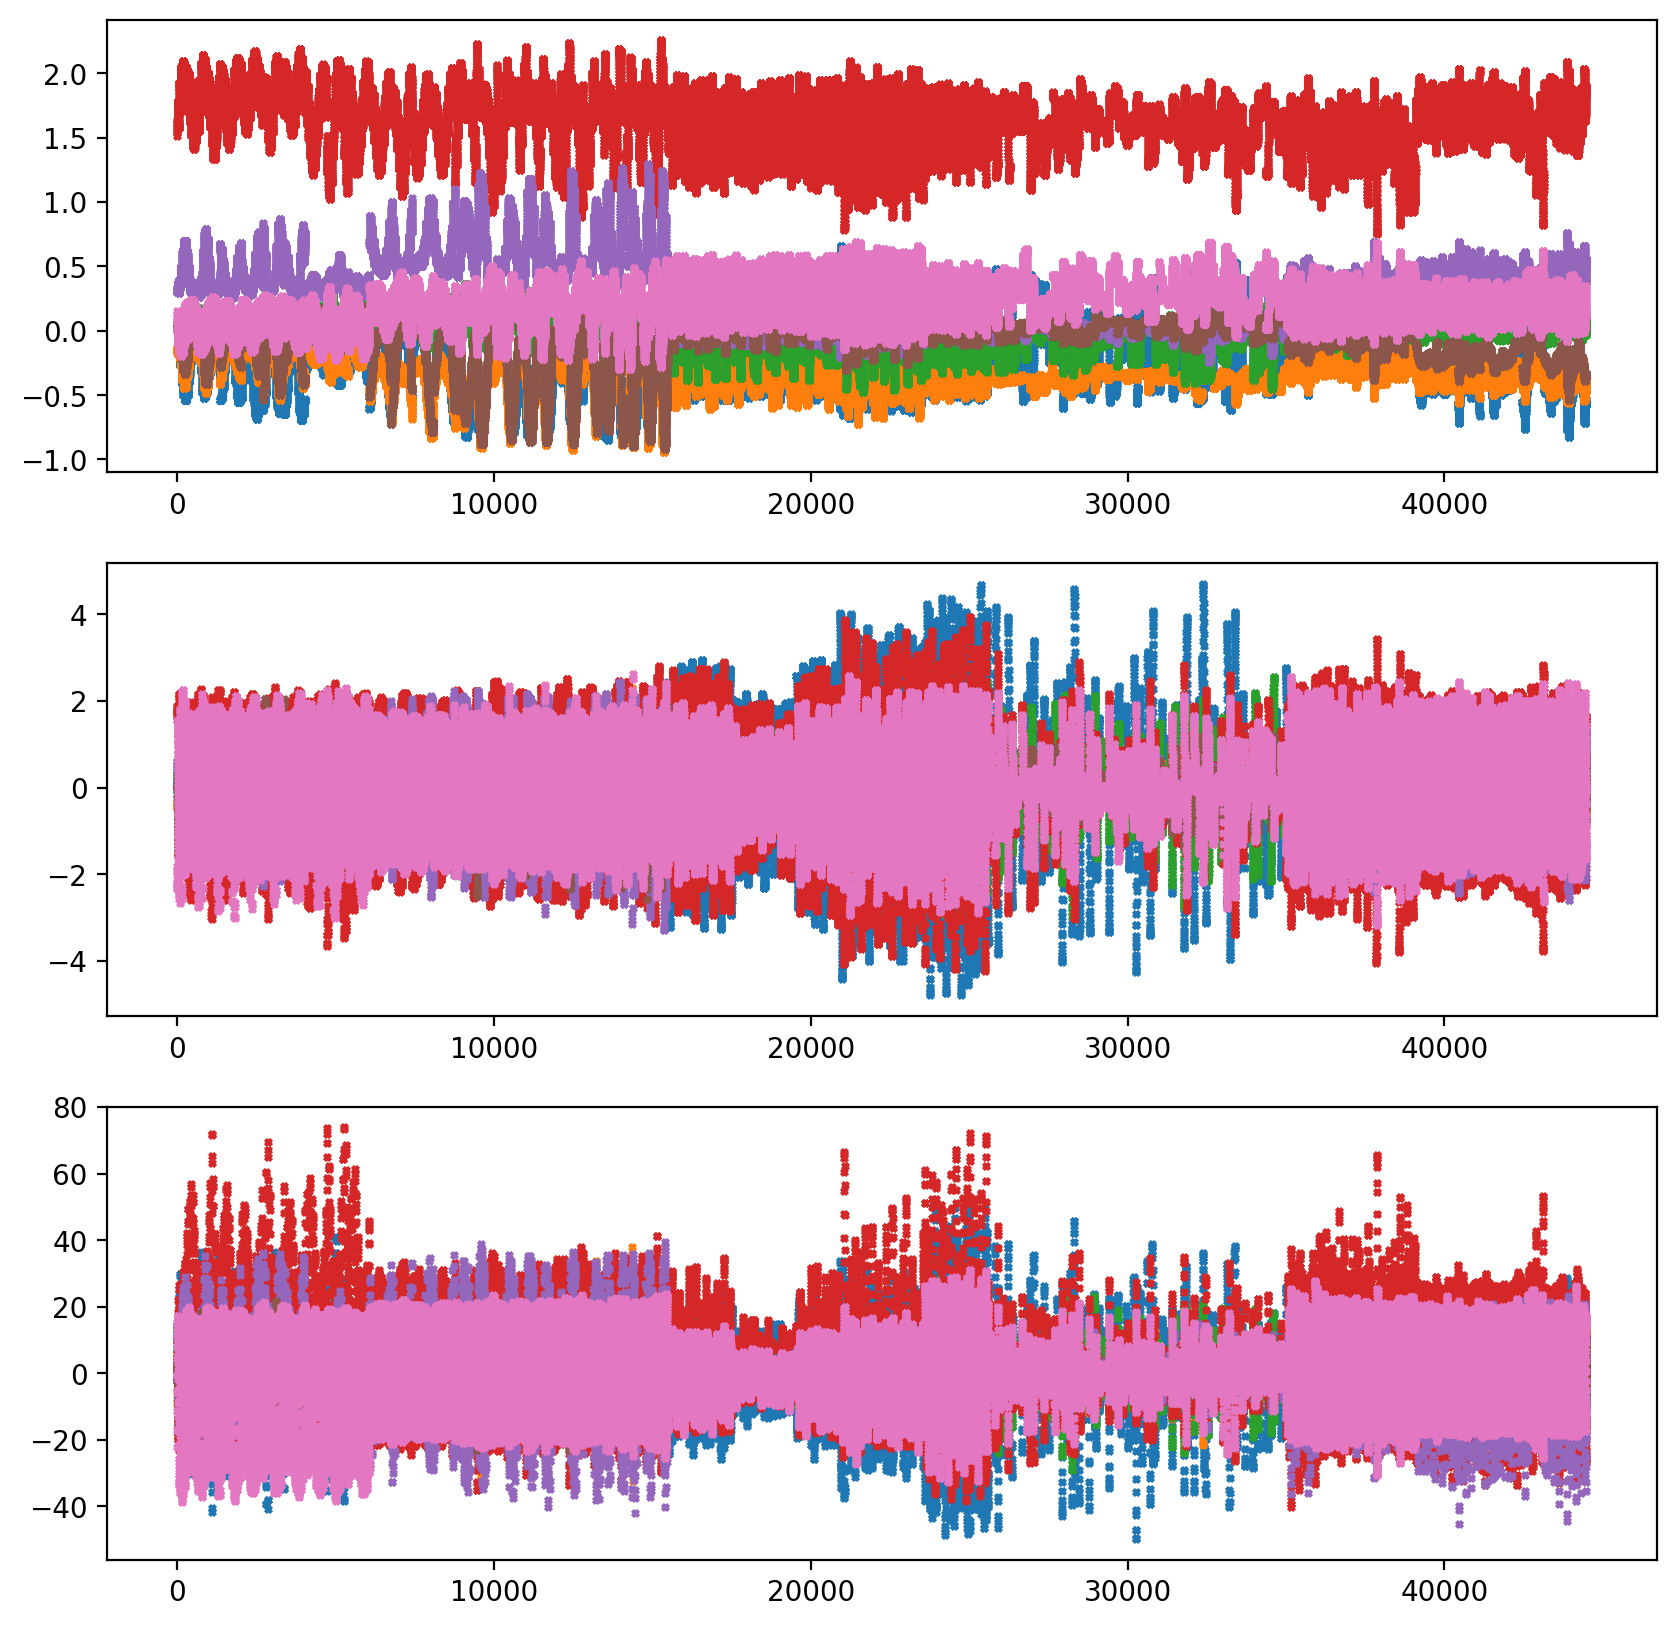

In [51]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_data(axs, data)

Pretty chaotic, huh... Well, it's over 44 thousand data points and our screen is only so wide... That's why we are going to look at a smaller, zoomed-in window from now on.

In [52]:
time_window_for_viz = slice(11000, 11050)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

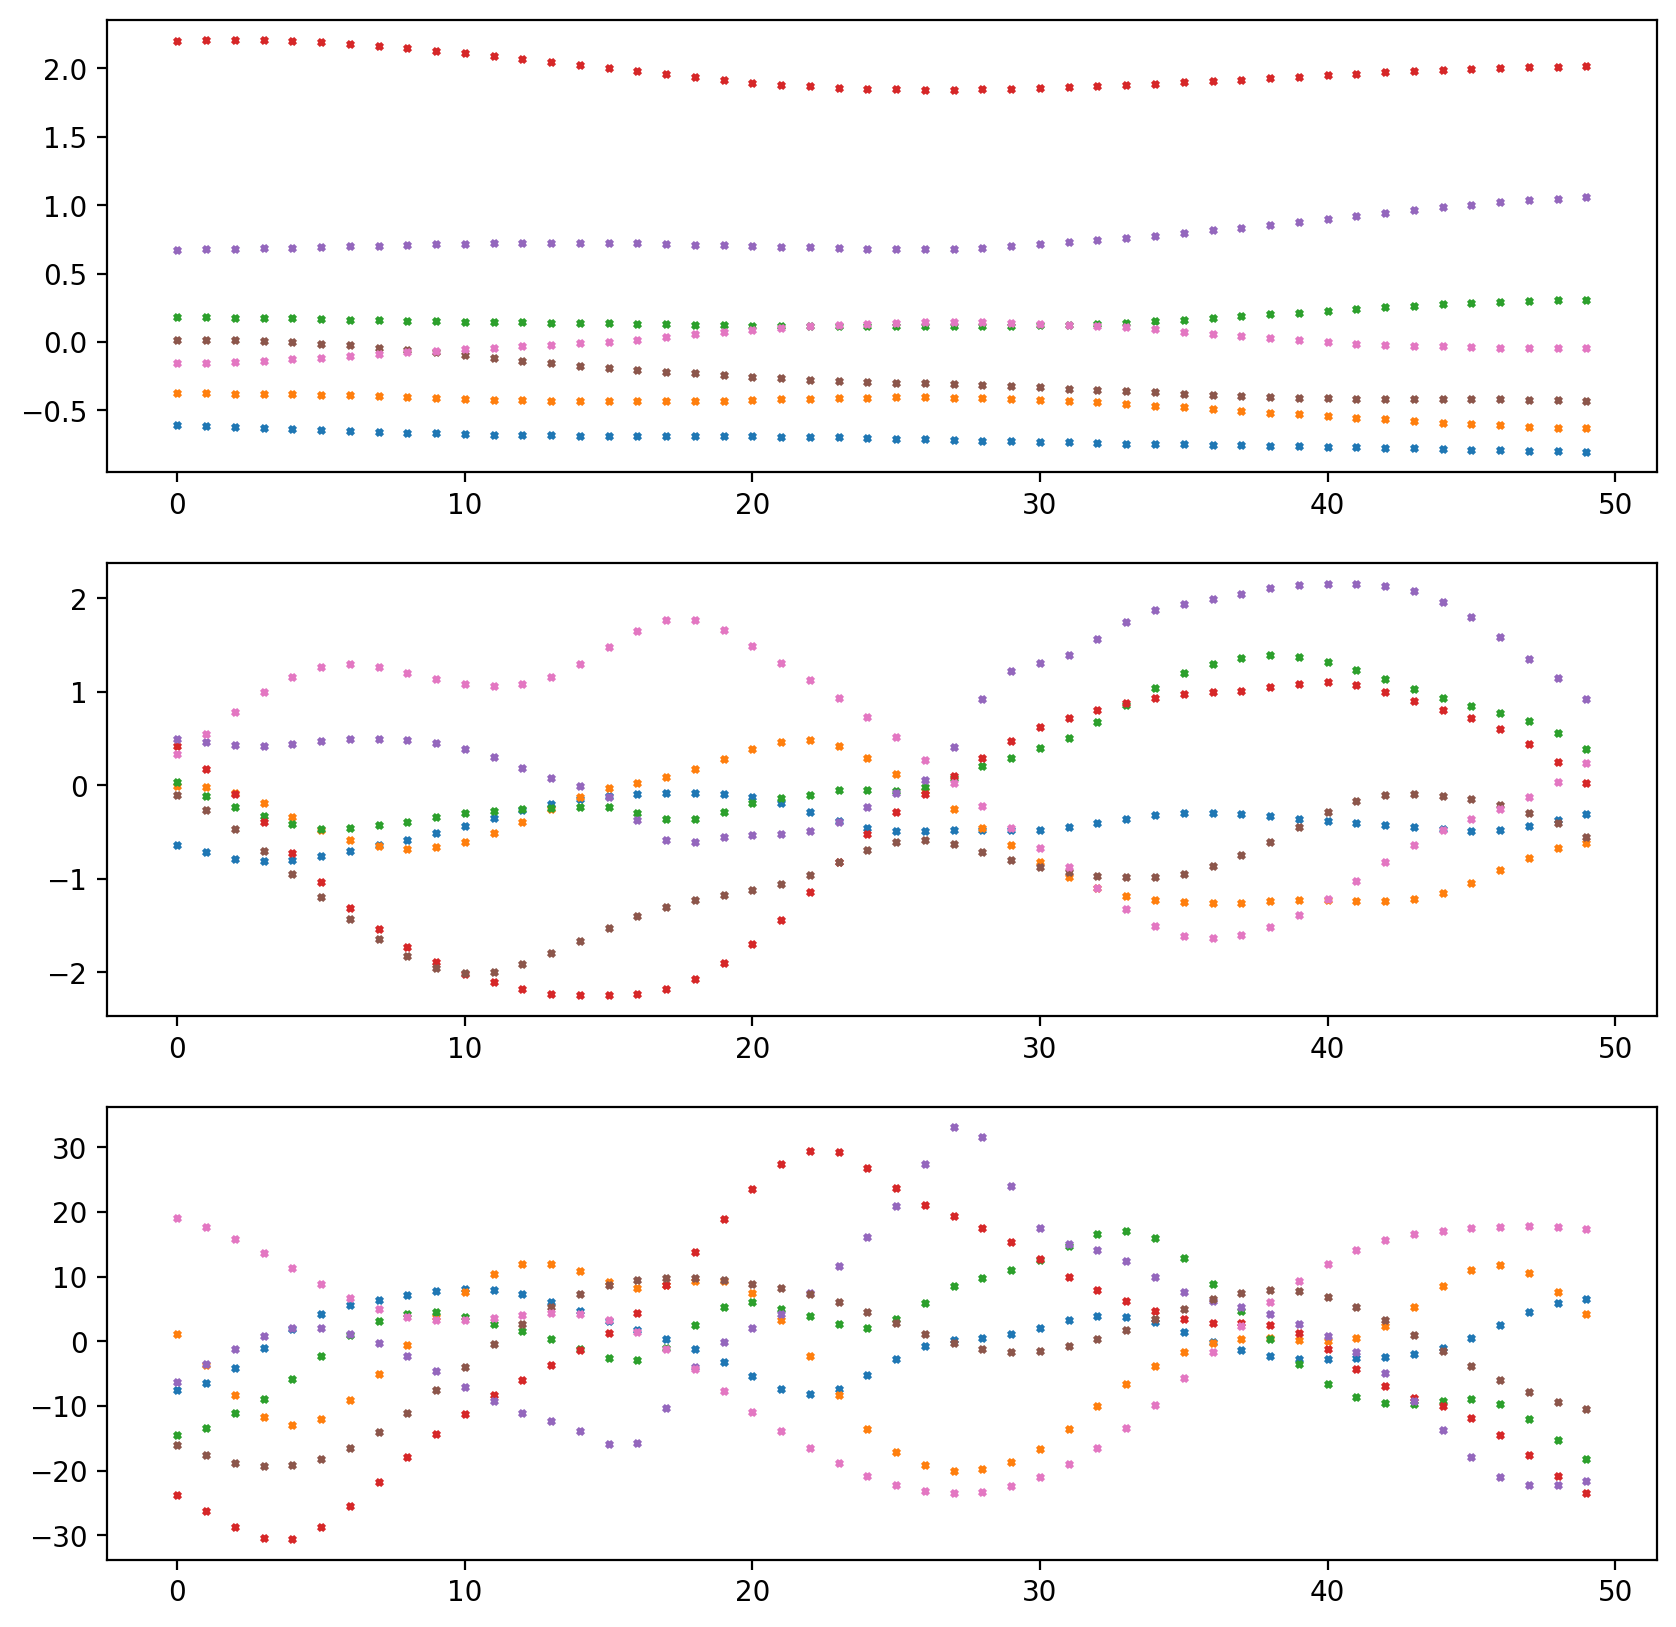

In [53]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_data(axs, data[time_window_for_viz, :])

# II. The Model

Ok, now that we have a feel for the data and what it looks like, we are going to set up a model.
What kind of model this is, we are going to be secretive about for now. Perhaps, you will learn about it in one of the following lectures? (Perhaps not, let's see).

#### The following two cells ...

... are mysterious functions that create us two matrices $A$ and $Q$, the transition matrix and process-noise covariance matrix of our linear, time-invariant Gaussian transition density.

**You do not have to understand what these two functions do, just take them for granted!** (I wouldn't try, anyway...)

#### The dynamics model (prior)

In [54]:
def mysterious_operation(F, L, dt):
    dim = F.shape[0]

    if L.ndim == 1:
        L = L.reshape((-1, 1))

    Phi = np.block(
        [
            [F, L @ L.T],
            [np.zeros(F.shape), -F.T],
        ]
    )
    M = sla.expm(Phi * dt)

    Ah = M[:dim, :dim]
    Qh = M[:dim, dim:] @ Ah.T

    return Ah, Qh

In [55]:
def create_mysterious_ssm(d, q, ell, dt, dff=1.0):
    F = np.diag(np.ones(q), 1)
    nu = q + 0.5
    D, lam = q + 1, np.sqrt(2 * nu) / ell
    F[-1, :] = np.array(
            [-ssp.binom(D, i) * lam ** (D - i) for i in range(D)]
        )
    
    L = np.eye(q+1)[-1, :] * dff
    A_1d, Q_1d = mysterious_operation(F, L, dt)
    A = np.kron(A_1d, np.eye(d))
    Q = np.kron(Q_1d, np.eye(d))
    return A, Q

In [56]:
dt = 1.0

In [57]:
A, Q = create_mysterious_ssm(DIM, NUM_DERIV, 10.0, dt, 50.0)

#### The measurement model (likelihood)

In [58]:
H = np.eye(STATE_DIM)  # We measure the entire state.
R = np.kron(np.diag(np.array([0.01, 0.01, 1.0])), np.eye(DIM))  # a (not-quite isotropic) sensor noise.

Finally, we set the initial moments to the first data point with some uncertainty.

In [59]:
m0 = data[0, :]
P0 = np.kron(np.diag(np.array([0.01, 0.01, 1.0])), np.eye(DIM))

# III. Inference

## Step 1: Filtering

In [60]:
def symmetrize(A):
    return 0.5 * (A + A.T) + (1e-8 * np.eye(A.shape[0]))

In [61]:
def kf_predict(m_filt, P_filt, A, Q):
    m_pred = A @ m_filt
    P_pred = A @ P_filt @ A.T + Q
    return m_pred, symmetrize(P_pred)

In [62]:
def kf_update(m_pred, P_pred, H, R, y):
    predicted_measurement = H @ m_pred
    innovation = (y - predicted_measurement)
    innovation_gramian = H @ P_pred @ H.T + R
    
    S_chol_fact = sla.cho_factor(symmetrize(innovation_gramian))
    cross_covariance = P_pred @ H.T
    kalman_gain = sla.cho_solve(S_chol_fact, cross_covariance.T).T
    
    mean_increment = kalman_gain @ innovation
    covariance_decrement = kalman_gain @ innovation_gramian @ kalman_gain.T
    
    m_filt = m_pred + mean_increment
    P_filt = P_pred - covariance_decrement
    return m_filt, symmetrize(P_filt)

In [63]:
def filter_kalman(m0, P0, A, Q, H, R, Y):
    d, D = H.shape
    N = Y.shape[0]
    result_mean = [m0.copy()]
    result_cov = [P0.copy()]
    m = m0.copy()
    P = P0.copy()
    for n in range(1, N):
        m, P = kf_predict(m, P, A, Q)
        m, P = kf_update(m, P, H, R, Y[n, :])
        result_mean.append(m.copy())
        result_cov.append(P.copy())
    return np.array(result_mean), np.array(result_cov)

In [64]:
%%time
kf_means, kf_covs = filter_kalman(m0, P0, A, Q, H, R, Y)

CPU times: user 5.5 s, sys: 221 ms, total: 5.72 s
Wall time: 4.76 s


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

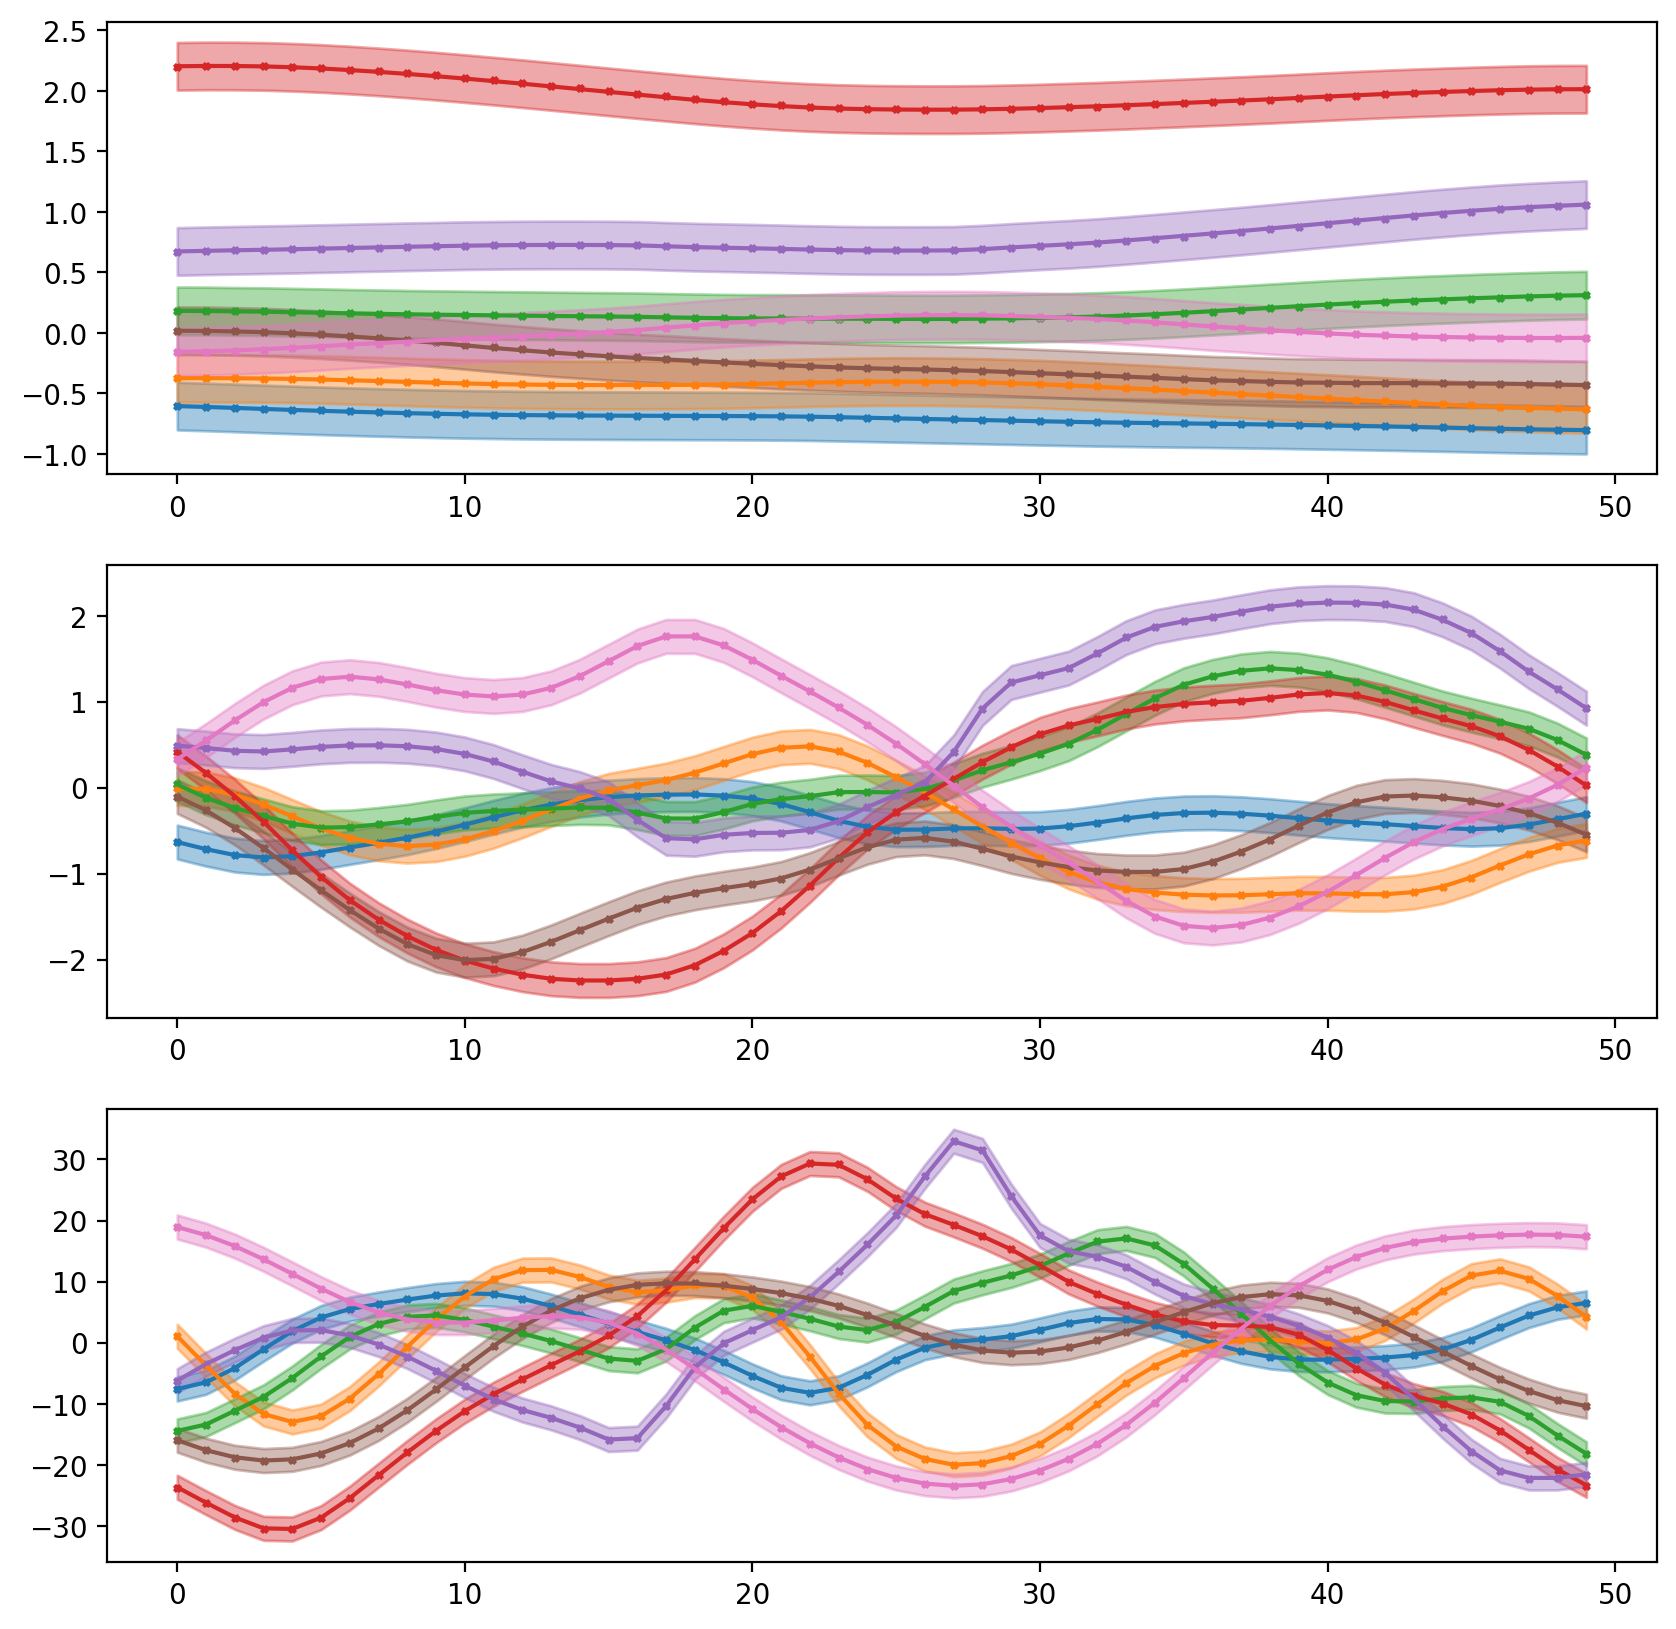

In [65]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_estimate(axs, kf_means[time_window_for_viz, :], kf_covs[time_window_for_viz, :, :])
plot_data(axs, data[time_window_for_viz, :])

## Step 2: Smoothing

In [66]:
for i in range(kf_covs.shape[0] - 1, 0, -1):
    assert np.all(np.linalg.eigvals(kf_covs[i, :, :]) > 0), f"matrix is not psd {np.linalg.eigvals(kf_covs[i, :, :])}"


## Task 1:

Implement a Rauch-Tung-Striebel smoother.
### (a)
Fill the function body of the function `smoother_step` below.
It takes as arguments
- `filt_m`, `filt_P`: the filtering moments at time step $k-1$
- `pred_m`, `pred_P`: the predicted moments at time step $k$
- `smooth_m`, `smooth_P`: the smoothed moments at time step $k$
- `A`, `Q`: the parameters of the transition density

The function must return a tuple containing
1. `xi` the smoothing mean at time step $k-1$
2. `Lambda` the smoothing covariance at time step $k-1$
3. `G` the smoothing gain used to compute the above

In [67]:
def smoother_step(filt_m, filt_P, pred_m, pred_P, smooth_m, smooth_P, A, Q):
    # 1. First we compute the gain factor for timestep k-1, using the 
    # filtered covariance at k-1 and the predicted covariance at k.
    # We use the transition matrix A to compute the gain factor.
    # assert np.allclose(pred_P.T, pred_P), "pred_P is not symmetric"
    
    # assert np.all(np.linalg.eigvals(pred_P) > 0), f"matrix is not psd {np.linalg.eigvals(pred_P)}"
    pred_P_cho_factor, _ = sla.cho_factor(pred_P, lower=True)
    pred_P_inverse = sla.cho_solve((pred_P_cho_factor, True), np.eye(pred_P.shape[0]))
    # assert pred_P_inverse.shape == pred_P.shape
    # assert np.isfinite(np.linalg.cond(pred_P)) , "A is not invertible"
    # assert np.allclose(pred_P @ pred_P_inverse, np.eye(pred_P.shape[0]), rtol=1e-8, atol=1e-8), "inverse is wrong"
    G = filt_P @ A.T @ pred_P_inverse # 
    # 2. Then we compute the smoothed mean at time-step k-1, using the
    # filtered mean at k-1 and the predicted mean at k, and the gain
    xi = filt_m + G @ (smooth_m - pred_m)
    # 3. Finally we compute the smoothed covariance at time-step k-1,
    # using the gain factor and the smoothed covariance at time-step k.
    Lambda = filt_P + G @ (smooth_P - pred_P) @ G.T
   
    assert xi.shape == filt_m.shape 
    assert Lambda.shape == filt_P.shape
    assert G.shape == filt_P.shape
    return xi, Lambda, symmetrize(G)
    
    

## (b)
Fill the function body of the function `rts_smooth` below. It takes as arguments
- `filter_means`
- `filter_covs`
- `A`, `Q`: the parameters of the transition density


### IMPORTANT
This function must return a tuple of three arrays:
- an $N \times D$-array containing the smoother means
- an $N \times D \times D$-array containing the smoother covariances 
- AND an $N \times D \times D$-array containing the smoother gains $G_k$ from every step. We will need the last one for later.

In [68]:
def rts_smooth(filter_means, filter_covs, A, Q):
    """
    RTS smoother for linear Gaussian state space models.
    """
    smoother_means = np.zeros_like(filter_means) 
    smoother_covs = np.zeros_like(filter_covs)
    smoother_gains = np.zeros_like(filter_covs)
    
    prev_smooth_mean = filter_means[-1, :] 
    prev_smooth_cov =symmetrize(filter_covs[-1, :, :])
    
    for i in range(filter_means.shape[0] - 1, 0, -1):
        filter_mean = filter_means[i, :]
        filter_cov = filter_covs[i, :, :]
        pred_mean, pred_cov = kf_predict(filter_mean, filter_cov, A, Q)
        prev_smooth_mean, prev_smooth_cov, G = smoother_step(filter_mean, filter_cov, 
                                                          pred_mean, pred_cov, 
                                                          prev_smooth_mean, prev_smooth_cov, A, Q)
        smoother_means[i-1, :] = np.array(prev_smooth_mean)
        smoother_covs[i-1, :, :] = np.array(prev_smooth_cov)
        smoother_gains[i-1, :, :] = np.array(G)
     
    assert filter_means.ndim == 2
    assert filter_covs.ndim == 3
    assert filter_means.shape[0] == filter_covs.shape[0]
    assert filter_means.shape[1] == filter_covs.shape[1]
    assert filter_covs.shape[1] == filter_covs.shape[2]
    
    return smoother_means, smoother_covs, smoother_gains

---

# Now we test your implementation.

**DO NOT CHANGE ANYTHING IN THESE CELLS**

In [69]:
%%time
rts_means, rts_covs, _ = rts_smooth(kf_means, kf_covs, A, Q)

CPU times: user 4.07 s, sys: 44 ms, total: 4.11 s
Wall time: 4.13 s


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

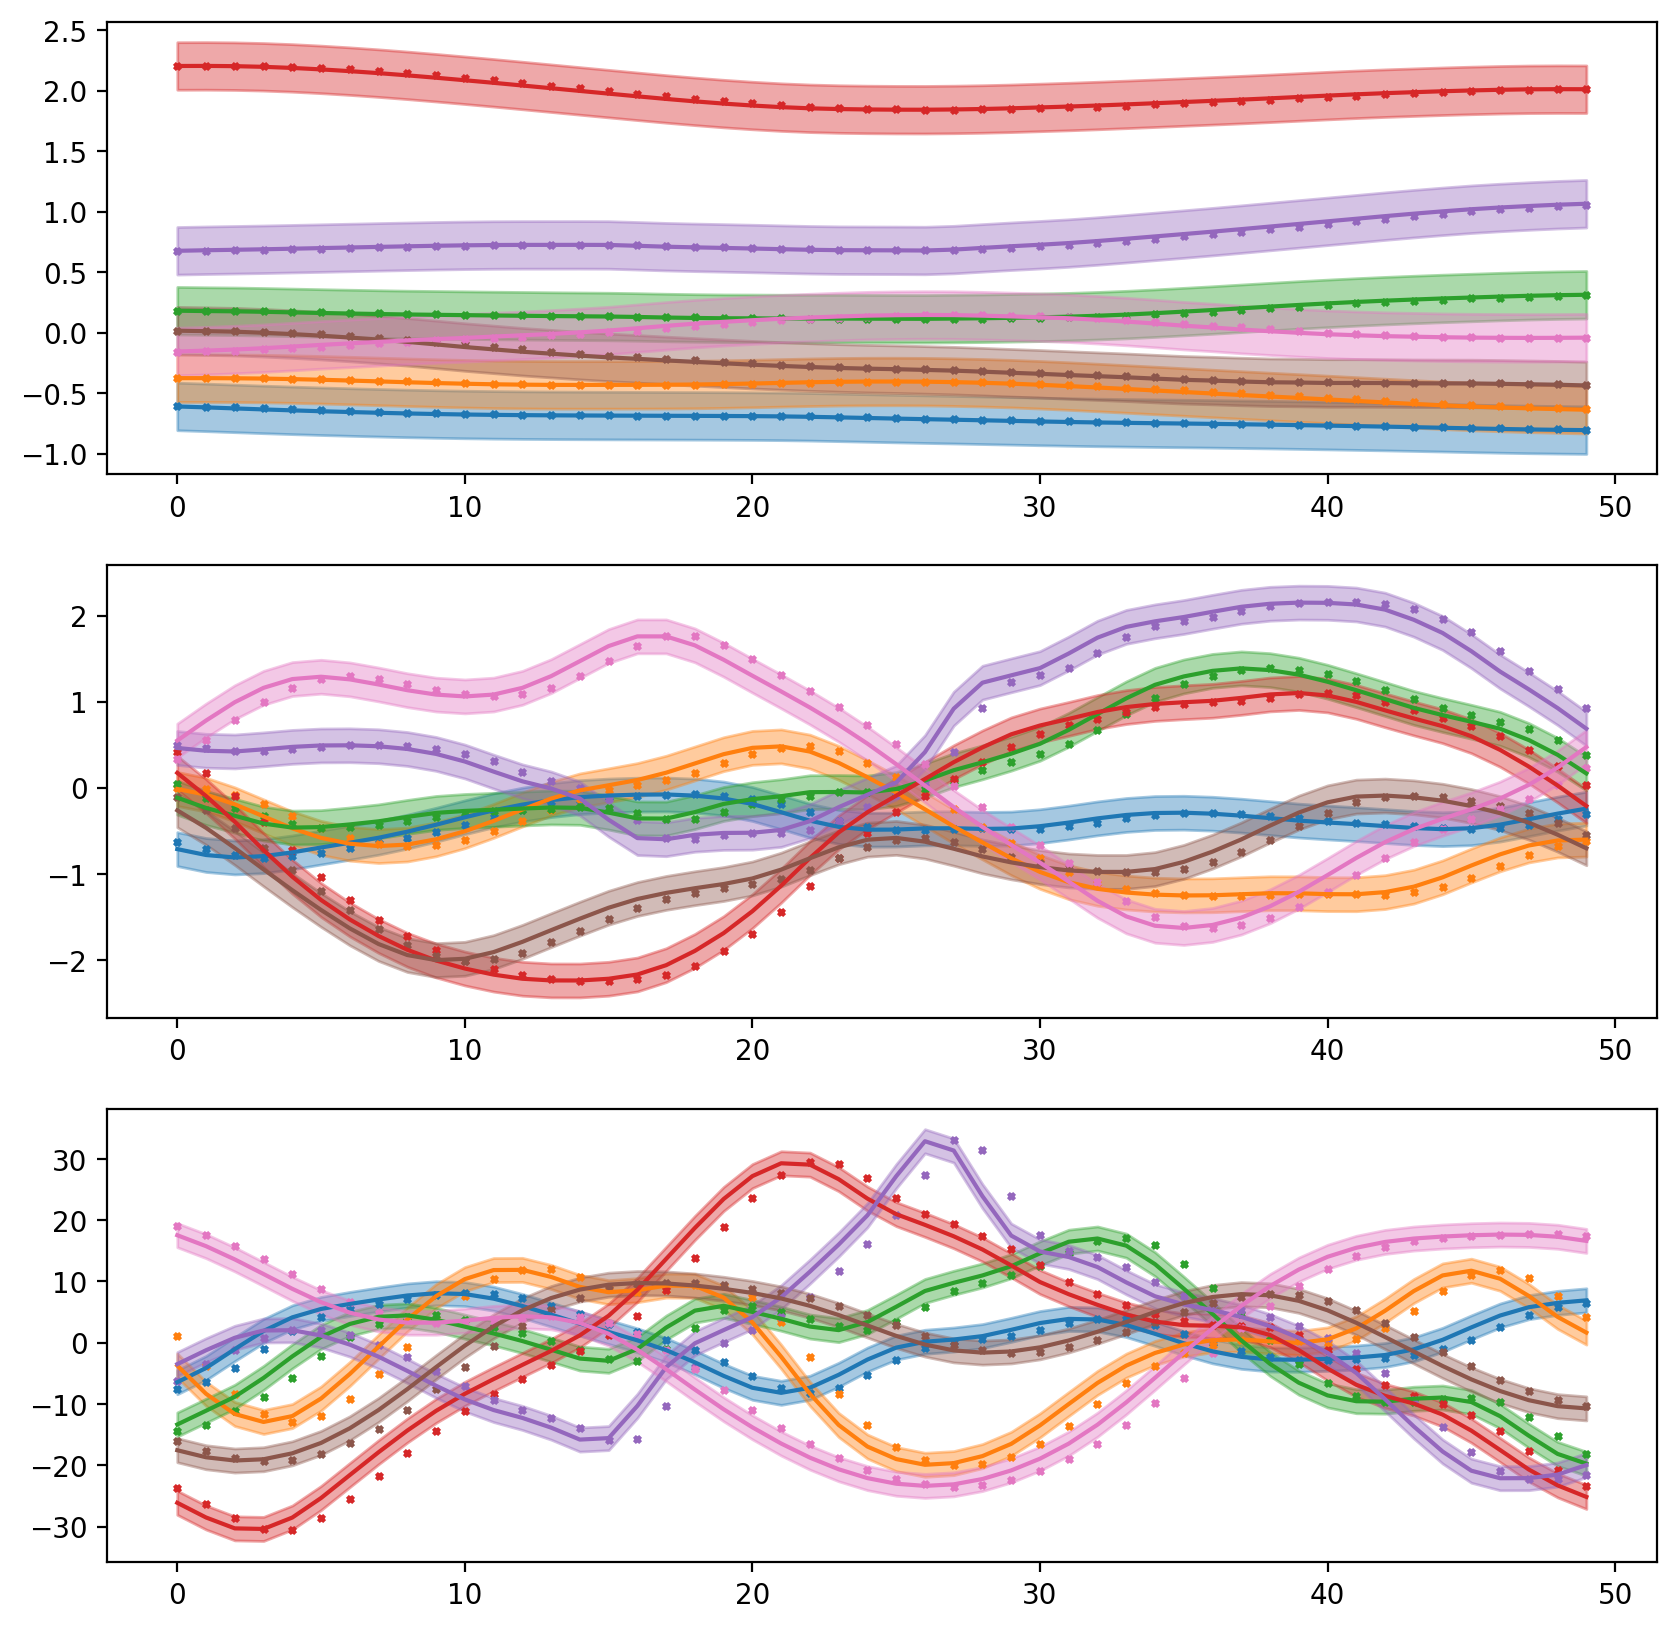

In [70]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_estimate(axs, rts_means[time_window_for_viz, :], rts_covs[time_window_for_viz, :, :])
plot_data(axs, data[time_window_for_viz, :])

---

## Task 2

All right, now - say - we do not have a good model for the data we see.
Take for example this transition model here, which is really just random Gaussian white noise in every step.

In [71]:
A_init = np.zeros((STATE_DIM, STATE_DIM))
Q_init = 0.01*np.diag(np.random.rand(STATE_DIM))

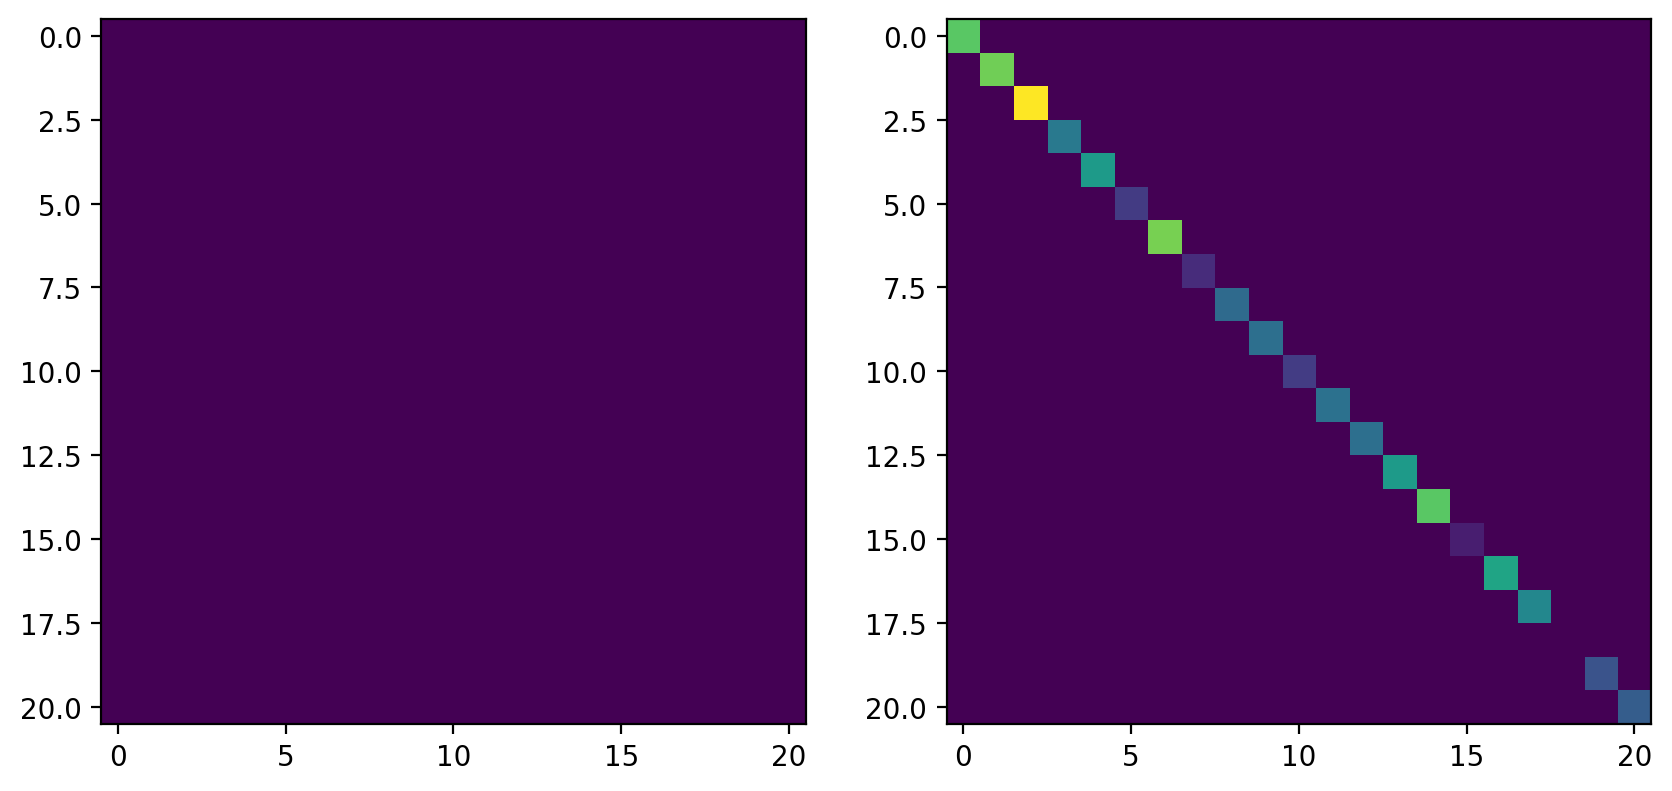

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(A_init)
axs[1].imshow(Q_init)

In [73]:
init_kf_means, init_kf_covs = filter_kalman(m0, P0, A_init, Q_init, H, R, Y)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

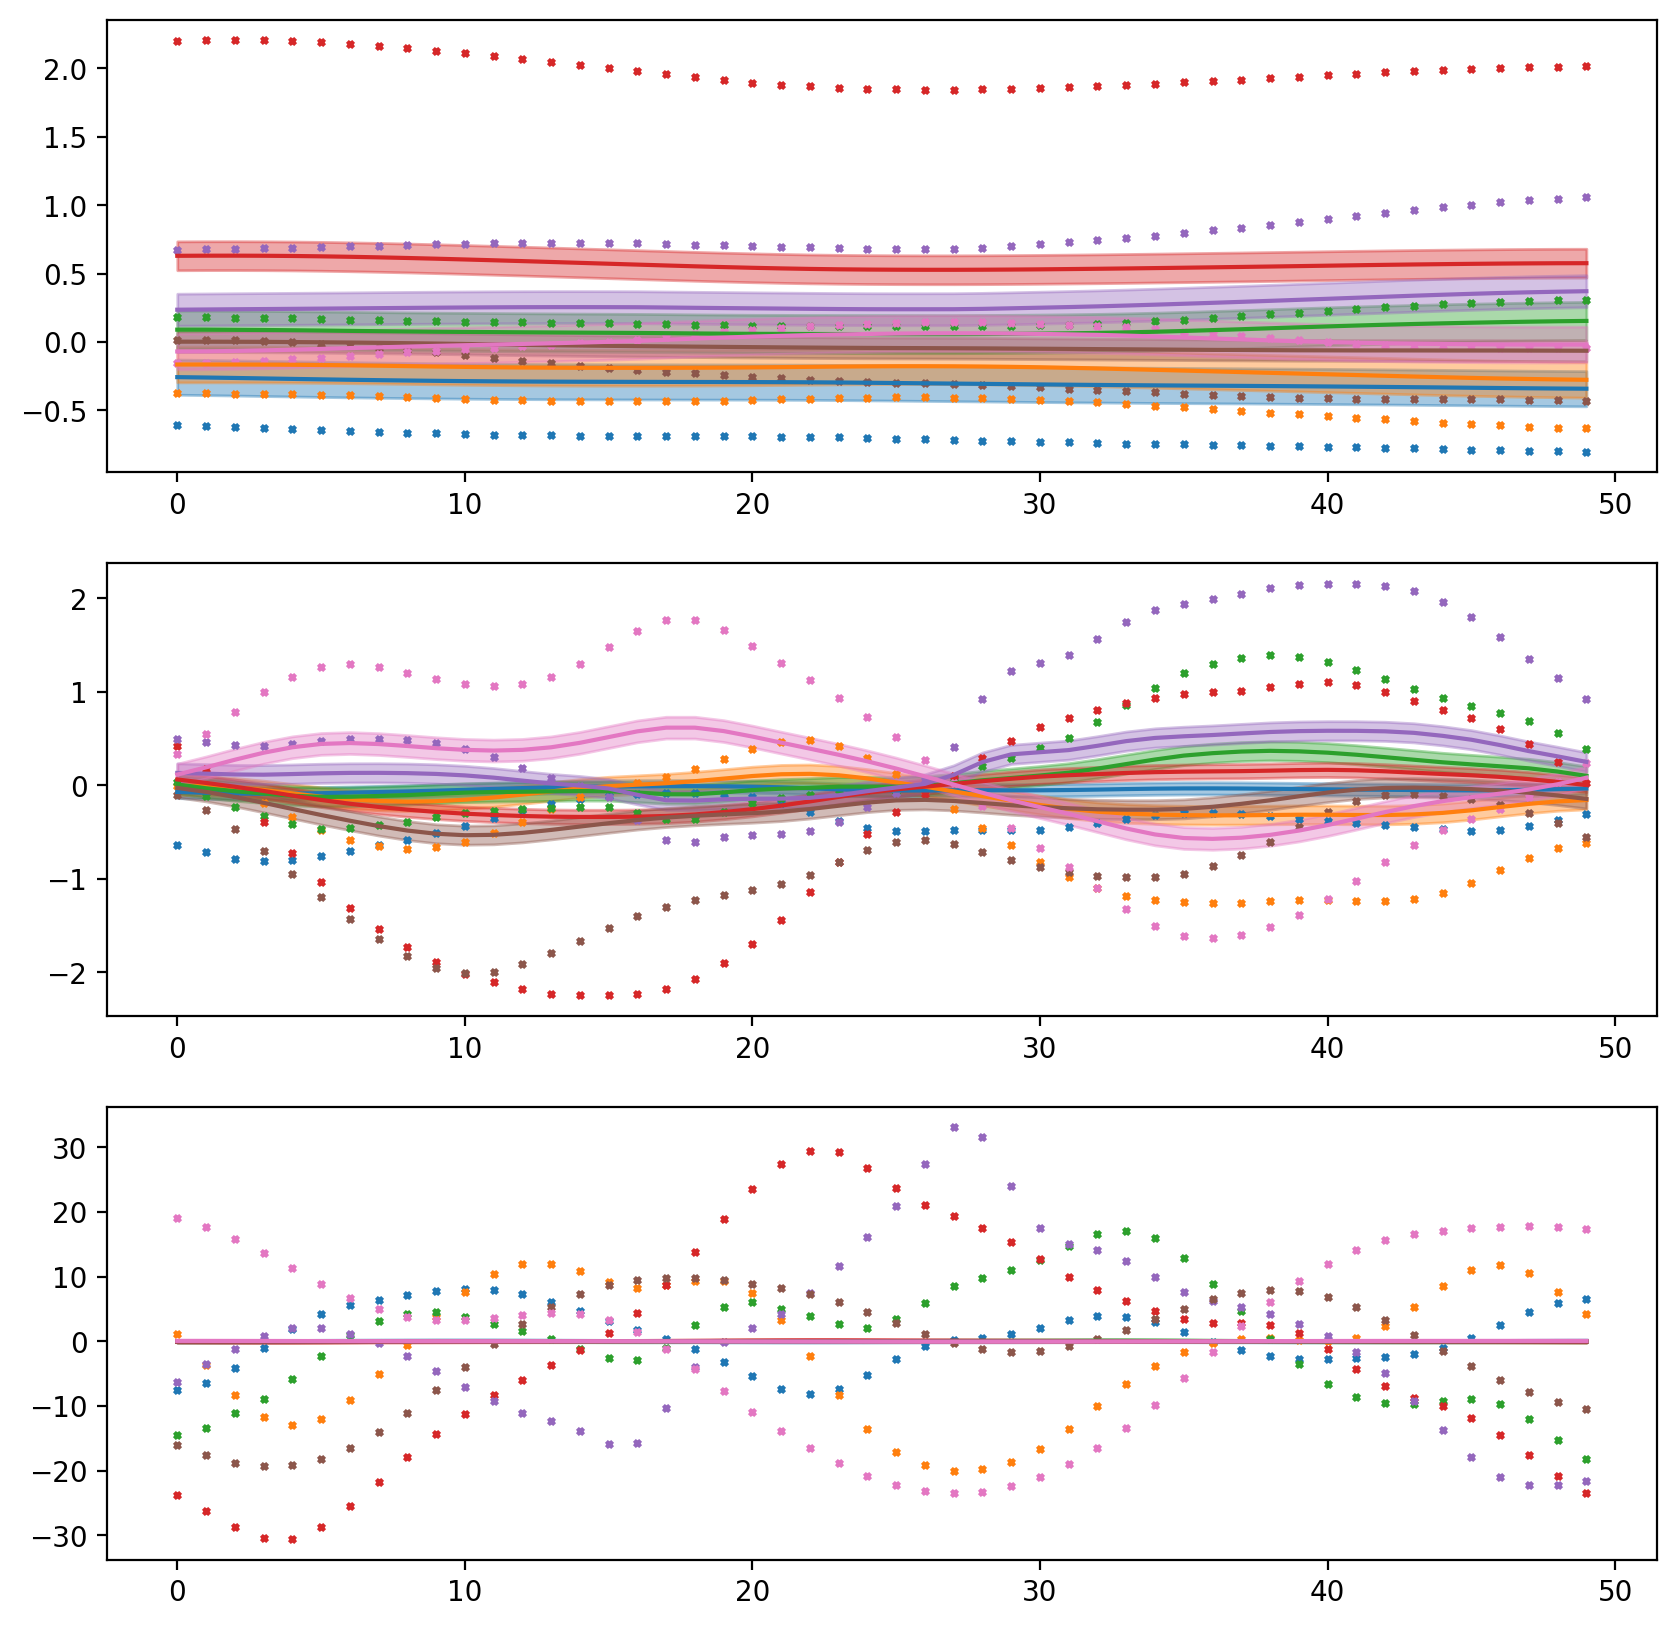

In [74]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_estimate(axs, init_kf_means[time_window_for_viz, :], init_kf_covs[time_window_for_viz, :, :])
plot_data(axs, data[time_window_for_viz, :])

Surprise, the fit is not so good. Luckily, you know a tool that might help.

# The EM-Algorithm for linear Gaussian state-space models

### (a) Implement the E-step of the EM algorithm 
as given in the theory exercise.
The function takes
- `m0`, `P0`: initial moments
- `A`, `Q`: a transition model
- `H`, `R`: a measurement model
- `Y`

The E-step computes a bunch of matrices

- `Sigma`
- `Phi`
- `B`
- `C`
- `D`

from the RTS smoother estimate given the current SSM and returns them.

In [94]:
def E_step(m0, P0, A, Q, H, R, Y):
    """
    m0: initial mean
    p0: initial covariance
    A: transition matrix
    Q: transition covariance
    H: observation matrix
    R: residual covariance
    Y: observations
    """
    N = Y.shape[0]
    kf_means, kf_covs = filter_kalman(m0, P0, A, Q, H, R, Y)
    rts_means, rts_covs, rts_gains = rts_smooth(kf_means, kf_covs, A, Q)
   
   
    Sigma = (1.0 / N) * np.sum([rts_covs[k, : , :] + np.outer(rts_means[k, :] , rts_means[k, :].T) for k in range(N)], axis=0)
    Phi = (1.0 / N) * np.sum([rts_covs[k-1, : , :] + np.outer(rts_means[k-1, :] , rts_means[k-1, :].T) for k in range(1, N)], axis=0)
    B = (1.0/ N) * np.sum([np.outer(Y[k, :] , rts_means[k, :].T)for k in range(N)], axis=0)
    # C - uses previous gains unlike term in assignment.
    C = (1.0 / N) * np.sum([ rts_covs[k, :, :] @ rts_gains[k-1, :, :].T + np.outer(rts_means[k, :] , rts_means[k-1, :].T) for k in range(N)], axis=0)
    D = (1.0 / N) * np.sum([np.outer(Y[k, :] , Y[k, :]) for k in range(N)], axis=0) 
   
    assert Sigma.shape == (STATE_DIM, STATE_DIM) 
    assert Phi.shape == (STATE_DIM, STATE_DIM) 
    assert B.shape == (STATE_DIM, STATE_DIM) 
    assert C.shape == (STATE_DIM, STATE_DIM) 
    assert D.shape == (STATE_DIM, STATE_DIM) 
    
    return Sigma, Phi, B, C, D

In [76]:
Sigma , Phi , B, C, D = E_step(m0, P0, A, Q, H, R, Y)
# print(Sigma.shape, Phi.shape, B.shape, C.shape, D.shape)

### (b) Compute the M-Step for the transition matrix $A$
based on the results of the E-Step

In [100]:
def M_step_A(Sigma, Phi, B, C, D):
    return C @ np.linalg.inv(symmetrize(Phi)) # TODO: do chofactor based invrese.

### (c) Compute the M-Step for the transition noise covariance $Q$
based on the results of the E-Step

In [101]:
def M_step_Q(Sigma, Phi, B, C, D, A):
    return symmetrize(Sigma  - C @ A.T  - A @ C.T  + A @ Phi @ A.T)

# From here on, DON'T CHANGE ANYTHING.

### This might take a while ☕️

---

In [102]:
def EM_AQ(m0, P0, A_init, Q_init, H, R, Y, n_iter):
    A_star = A_init.copy()
    Q_star = Q_init.copy()
    
    for i in range(n_iter):
        print("EM-Step {}".format(i+1))
        # Sigma, Phi, B, C, D = E_step(m0, P0, A, Q_star, H, R, Y)
        Sigma, Phi, B, C, D = E_step(m0, P0, A_star, Q_star, H, R, Y)
        A_star = M_step_A(Sigma, Phi, B, C, D)
        # Q_star = M_step_Q(Sigma, Phi, B, C, D, A)
        Q_star = M_step_Q(Sigma, Phi, B, C, D, A_star)
    return A_star, Q_star

In [103]:
A_star, Q_star = EM_AQ(m0, P0, A_init, Q_init, H, R, Y, 100)

EM-Step 1
EM-Step 2
EM-Step 3
EM-Step 4
EM-Step 5
EM-Step 6


LinAlgError: 1-th leading minor of the array is not positive definite

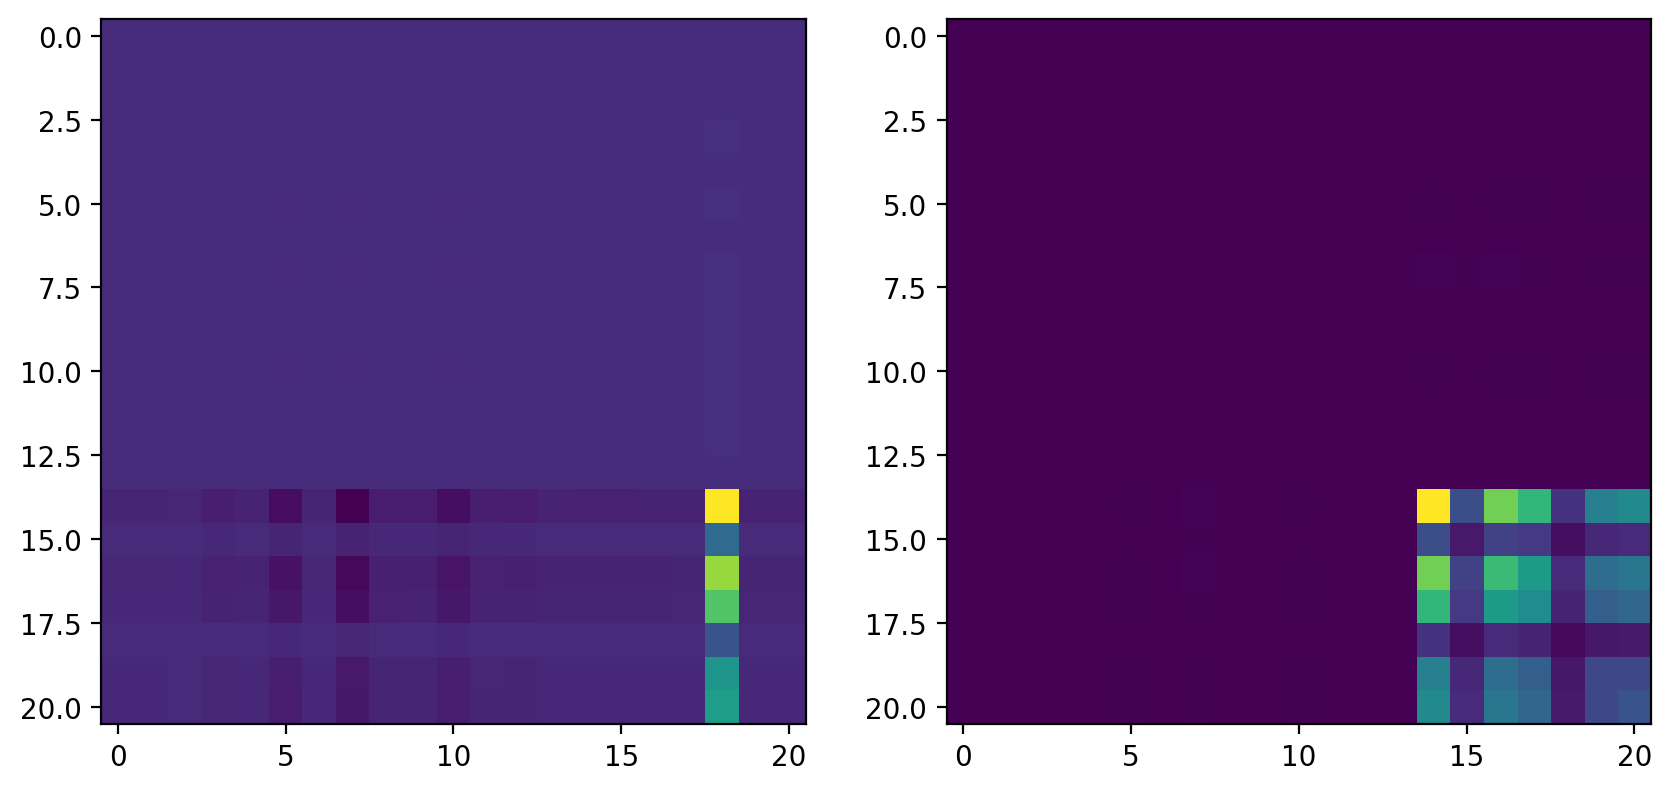

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
axs[0].imshow(A_star)
axs[1].imshow(Q_star)

In [84]:
%%time
kf_means_2, kf_covs_2 = filter_kalman(m0, P0, A_star, Q_star, H, R, Y)

CPU times: user 4.68 s, sys: 71.8 ms, total: 4.75 s
Wall time: 4.8 s


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

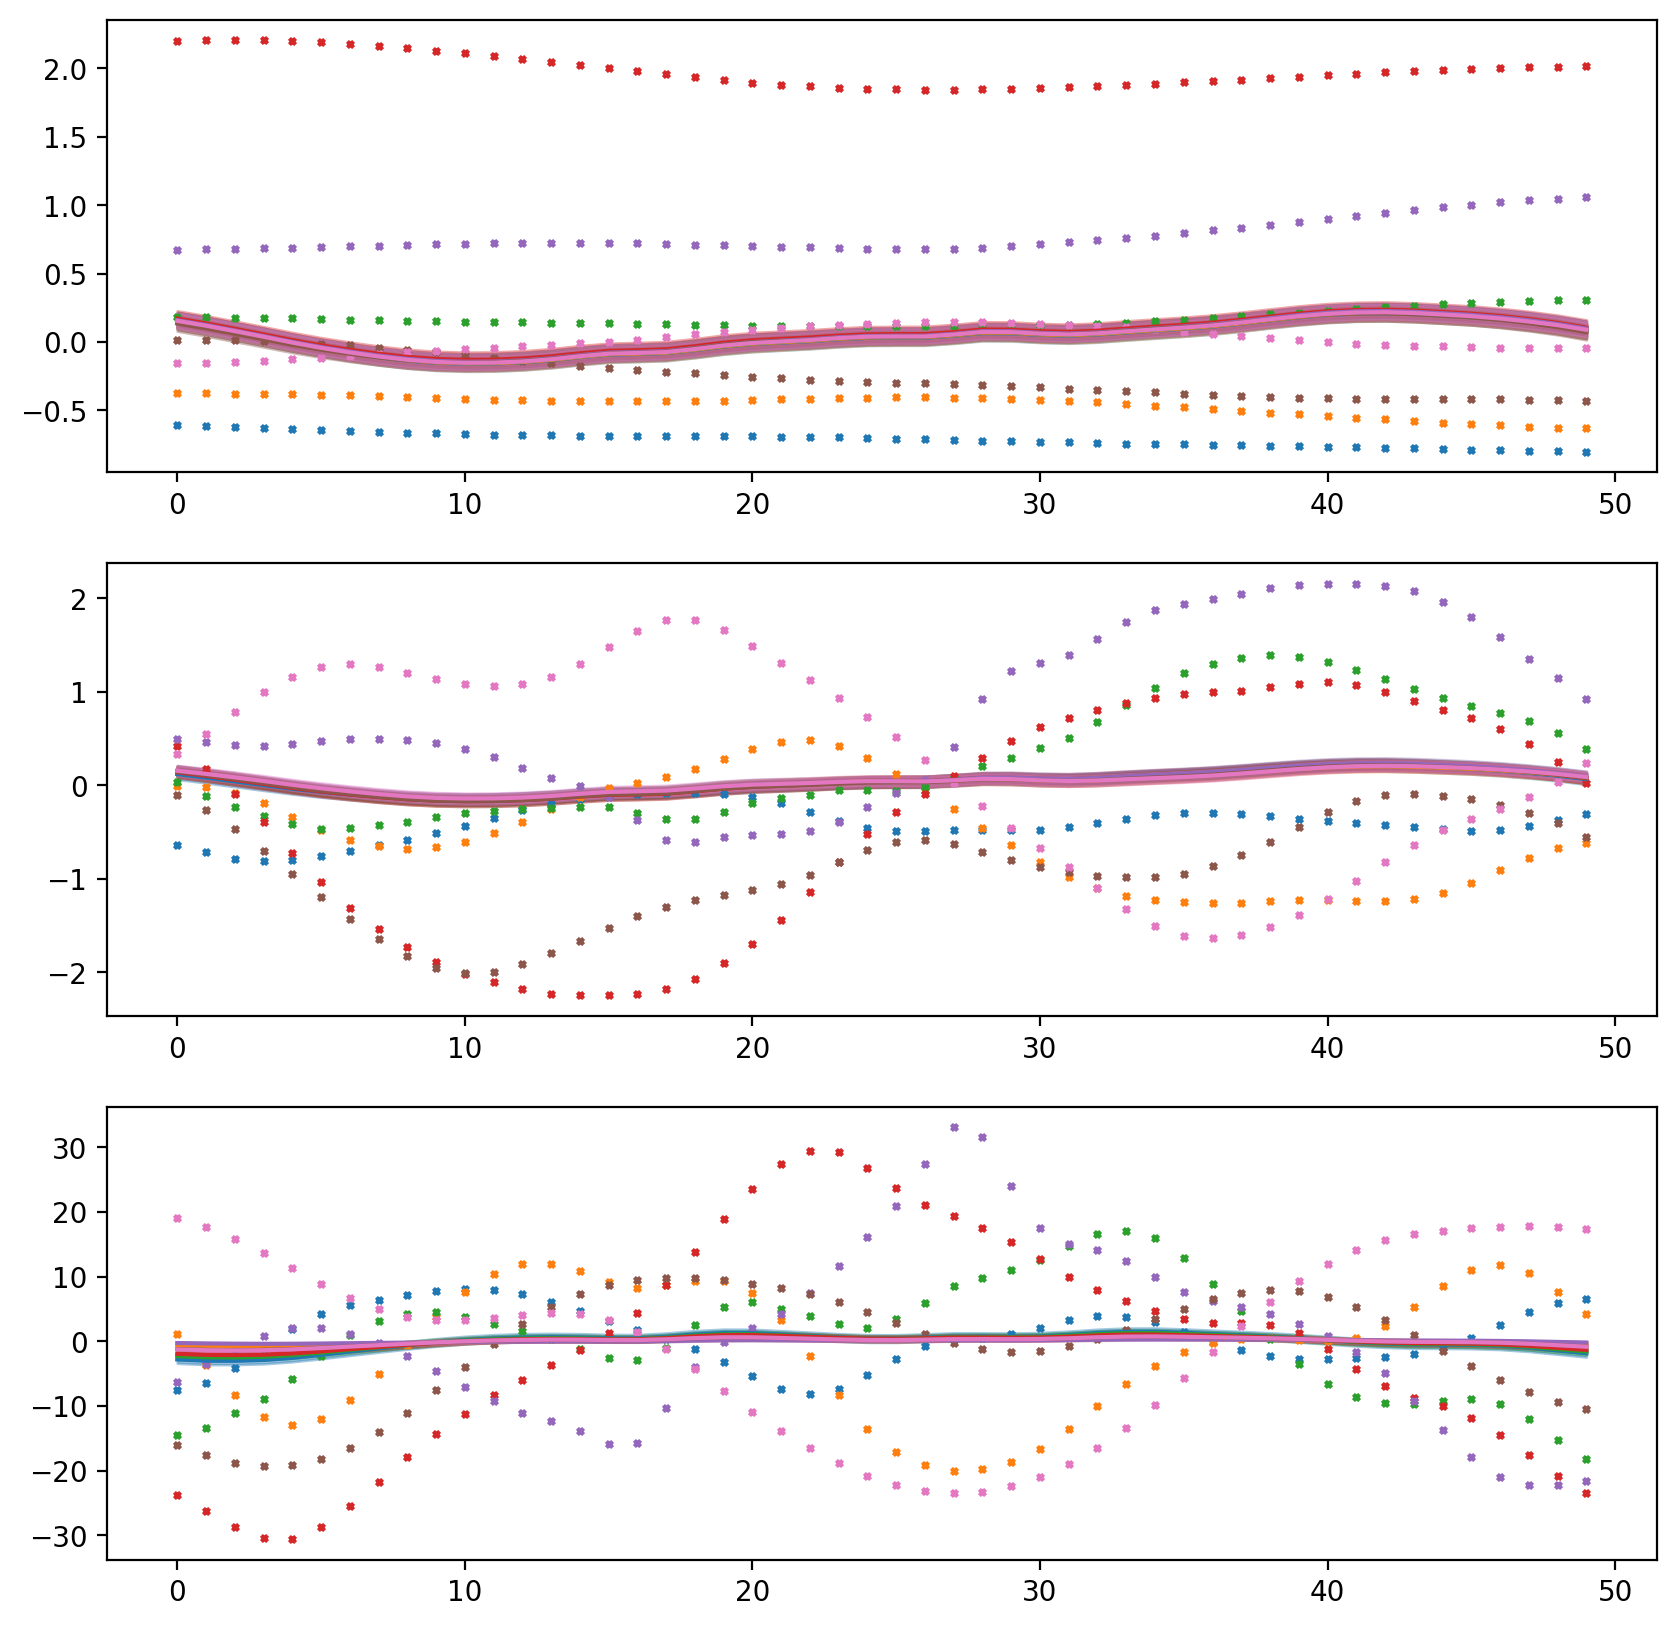

In [85]:
fig, axs = plt.subplots(3,1, figsize=(10, 10))
plot_estimate(axs, kf_means_2[time_window_for_viz, :], kf_covs_2[time_window_for_viz, :, :])
plot_data(axs, data[time_window_for_viz, :])

---

## If everything went as planned, ...
... you should see a good model with a fine fit now.

### How to submit your work:

Export your answer into a pdf (for example using jupyter's `Save and Export Notebook as` feature in the `File` menu). Make sure to include all outputs, in particular plots. Also include your answer to the theory question, either by adding it as LaTeX code directly in the notebook, or by adding it as an extra page (e.g. a scan) to the pdf. Submit the exercise on Ilias, in the associated folder. **Do not forget to add your name(s) and matrikel number(s) above!)**